In [83]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

# Build Dataset:

In [84]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [85]:
def build_dataset(X, y, shuffle=False, BATCH_SIZE=1024):
    BUFFER_SIZE = len(y)
    X = tf.cast(X[...,tf.newaxis]/255, tf.float32)
    y = tf.cast(y,tf.int64)
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [86]:
train_ds = build_dataset(X_train, y_train)
valid_ds = build_dataset(X_valid, y_valid)
test_ds = build_dataset(X_test, y_test)

# LeNet-5 Model:

In [87]:
class LeNet5(tf.keras.Model):
    def __init__(self, dropout=0.25):
        super(LeNet5, self).__init__()
        self.dropout = dropout
        self.conv1 = tf.keras.layers.Conv2D(filters=6, 
                                            kernel_size=(3, 3), 
                                            activation='relu')
        self.pool1 = tf.keras.layers.AveragePooling2D()
        self.conv2 = tf.keras.layers.Conv2D(filters=16, 
                                            kernel_size=(3, 3), 
                                            activation='relu')
        self.pool2 = tf.keras.layers.AveragePooling2D()
        self.fc1 = tf.keras.layers.Dense(units=120, activation='relu')
        self.fc2 = tf.keras.layers.Dense(units=84, activation='relu')
        self.fc3 = tf.keras.layers.Dense(units=10)
        self.drop1 = tf.keras.layers.Dropout(self.dropout)
        self.drop2 = tf.keras.layers.Dropout(self.dropout)

    def call(self, inputs, training=False):
        outputs = self.conv1(inputs)
        outputs = self.pool1(outputs)
        outputs = self.conv2(outputs)
        outputs = self.pool2(outputs)
        outputs = tf.keras.layers.Flatten()(outputs)
        outputs = self.drop1(self.fc1(outputs), training=training)
        outputs = self.drop2(self.fc2(outputs), training=training)
        outputs = self.fc3(outputs)
        return outputs

In [88]:
model = LeNet5()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
cp_cb = tf.keras.callbacks.ModelCheckpoint(filepath='model/model.ckpt',
                                           save_best_only=True,
                                           save_weights_only=True,
                                           verbose=1)

In [89]:
model.load_weights('model/model.ckpt')

In [125]:
y_pred = model.predict(test_ds)

In [126]:
incorrent_index = np.where(y_test != np.argmax(y_pred, -1))[0]

In [127]:
digit, index = np.unique(y_test[incorrent_index], return_index=True)
incorrent_index = incorrent_index[index]

In [128]:
y_pred = y_pred[incorrent_index].argmax(1)
y_true = y_test[incorrent_index]

In [131]:
example = X_test[incorrent_index]
img_name_tensors = {"Label: {}, Prediction: {}".format(y1, y2): v for v, y1, y2 in zip(tf.cast(example[...,tf.newaxis]/255, tf.float32), y_true, y_pred)}

In [149]:
keys = list(img_name_tensors.keys())

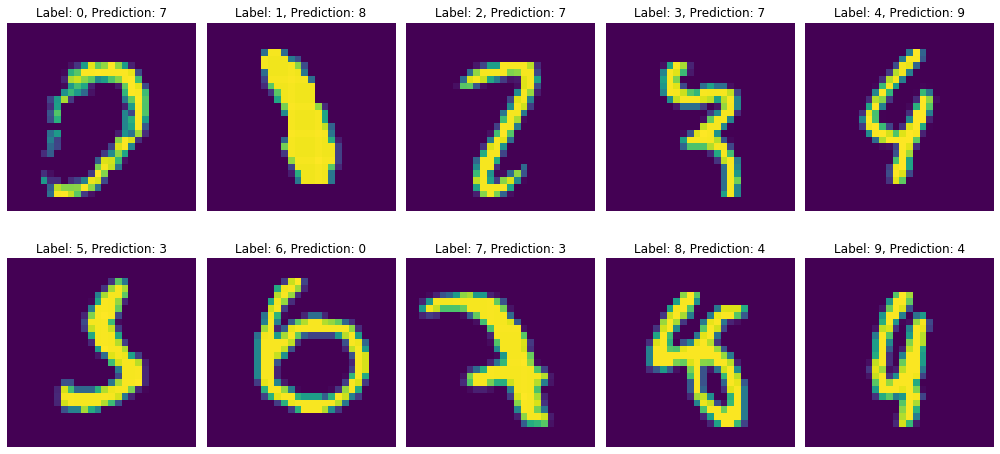

In [139]:
fig, ax = plt.subplots(2, 5, figsize=(14,7))
ax = ax.flatten()
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
    ax[n].imshow(tf.squeeze(img_tensors, -1))
    ax[n].set_title(name)
    ax[n].axis('off')
plt.tight_layout()

In [144]:
baseline = tf.zeros(shape=(28,28,1))
alphas = tf.linspace(start=0.0, stop=1.0, num=51)

In [145]:
def interpolate_images(baseline,
                       image,
                       alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

In [150]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors[keys[0]],
    alphas=alphas)

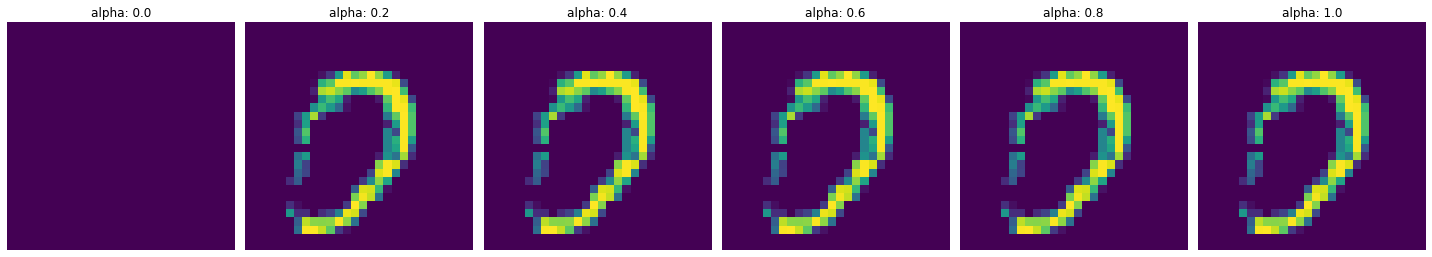

In [151]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(tf.squeeze(image, -1))
    plt.axis('off')

plt.tight_layout()

In [152]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

In [153]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=tf.constant(0))

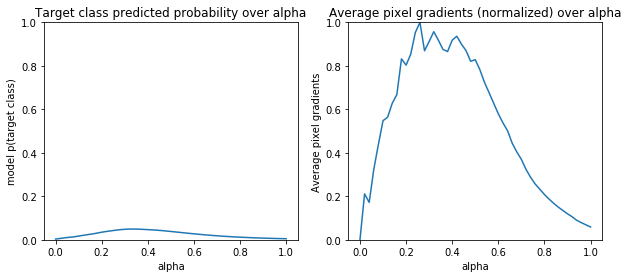

In [154]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 0]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

In [155]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [156]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=300,
                         batch_size=32):
    # 1. Generate alphas
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps)

    # Accumulate gradients across batches
    integrated_gradients = 0.0

    # Batch alpha images
    ds = tf.data.Dataset.from_tensor_slices(alphas).batch(batch_size)

    for batch in ds:

        # 2. Generate interpolated images
        batch_interpolated_inputs = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=batch)

        # 3. Compute gradients between model outputs and interpolated inputs
        batch_gradients = compute_gradients(images=batch_interpolated_inputs,
                                            target_class_idx=target_class_idx)

        # 4. Average integral approximation. Summing integrated gradients across batches.
        integrated_gradients += integral_approximation(gradients=batch_gradients)

    # 5. Scale integrated gradients with respect to input
    scaled_integrated_gradients = (image - baseline) * integrated_gradients
    return scaled_integrated_gradients

In [166]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          name,
                          m_steps=tf.constant(50),
                          cmap=None,
                          overlay_alpha=0.4):

    attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

    # Sum of the attributions across color channels for visualization.
    # The attribution mask shape is a grayscale image with height and width
    # equal to the original image.
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))
    
    fig.suptitle(name)

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(tf.squeeze(baseline, -1))
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(tf.squeeze(image, -1))
    axs[0, 1].axis('off')

    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(tf.squeeze(image, -1), alpha=overlay_alpha)
    axs[1, 1].axis('off')

#     plt.tight_layout()
    fig.savefig('images/{}-plot.png'.format(target_class_idx), format='png', dpi=300)
    return fig

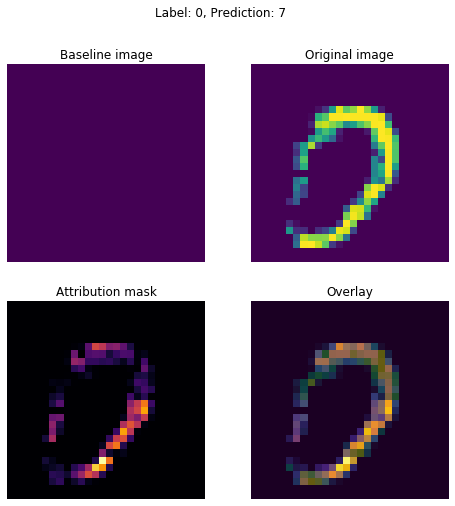

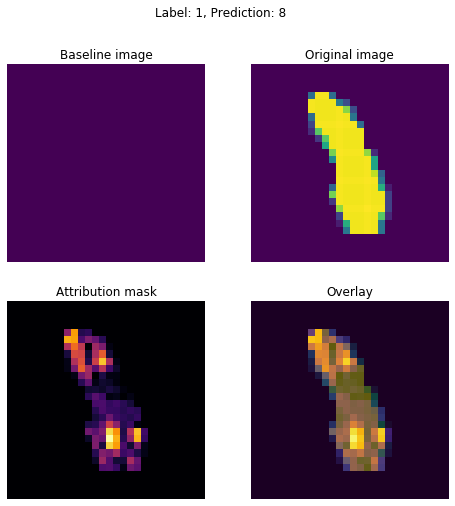

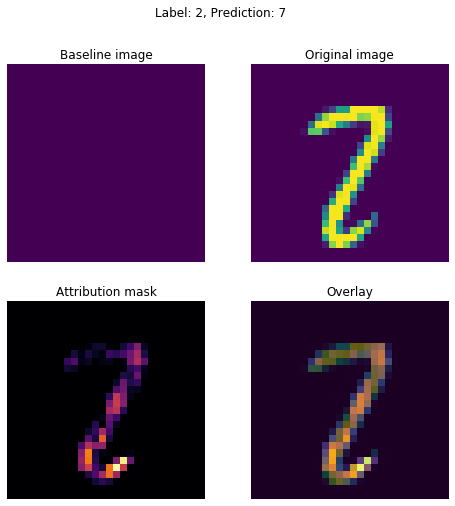

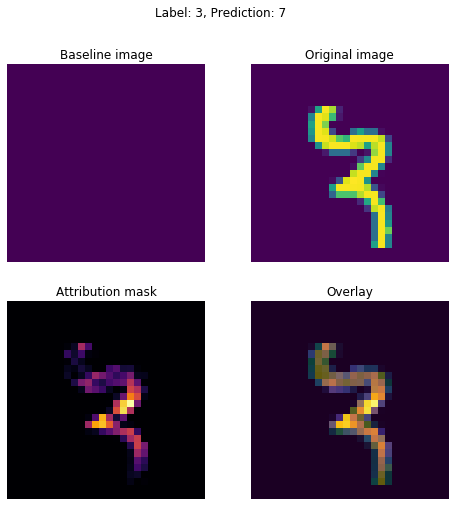

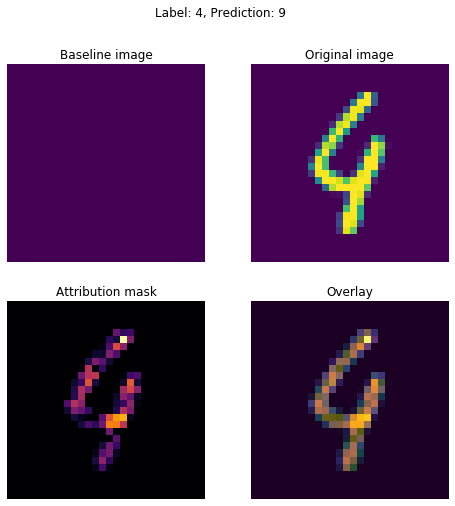

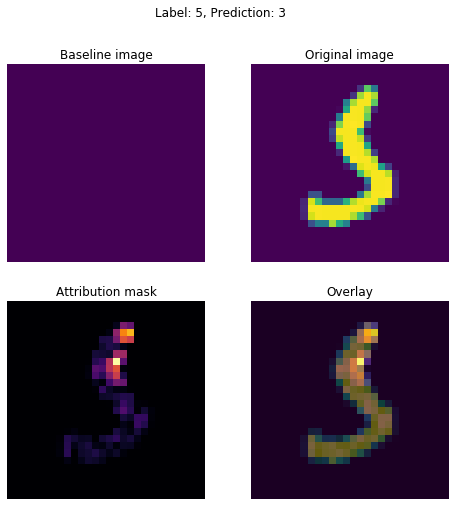

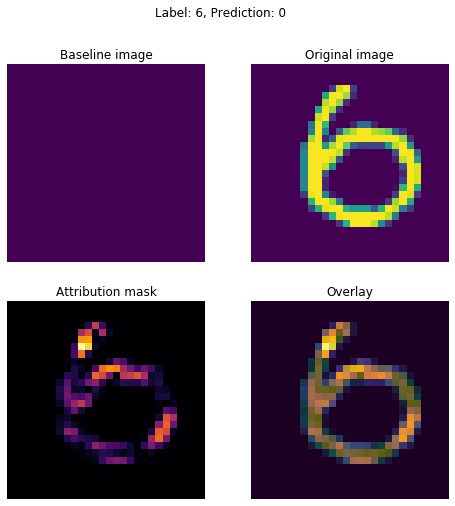

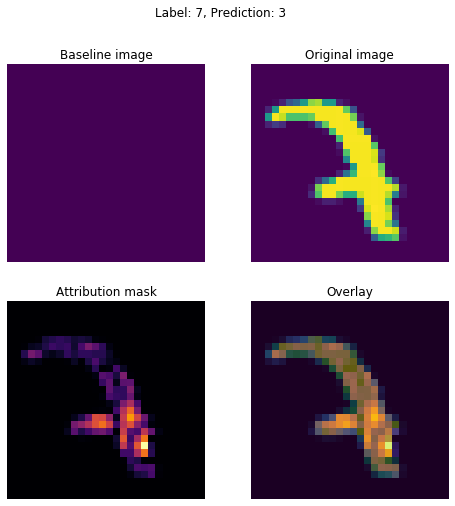

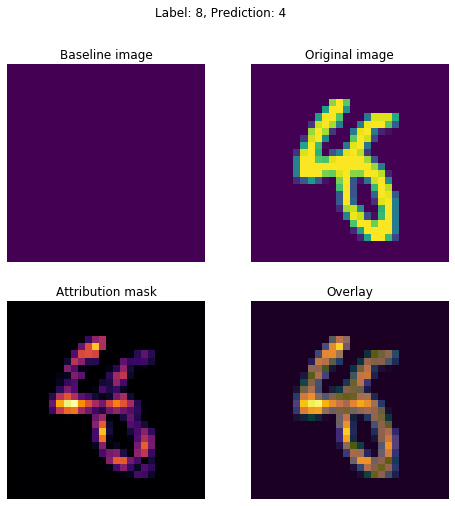

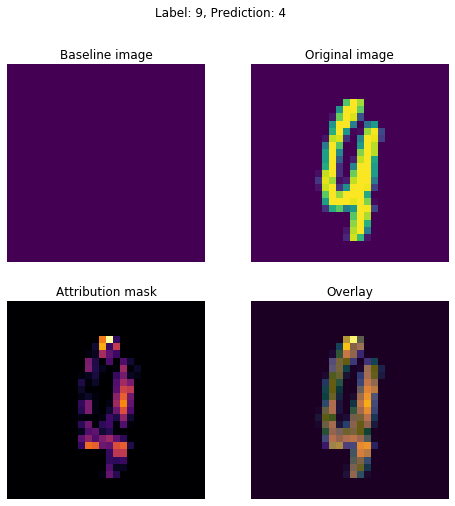

In [167]:
for i in range(10):
    _ = plot_img_attributions(image=img_name_tensors[keys[i]],
                              baseline=baseline,
                              target_class_idx=i,
                              name=keys[i],
                              m_steps=2400,
                              cmap=plt.cm.inferno,
                              overlay_alpha=0.4)